In [2]:
pip install torch torchbnn numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

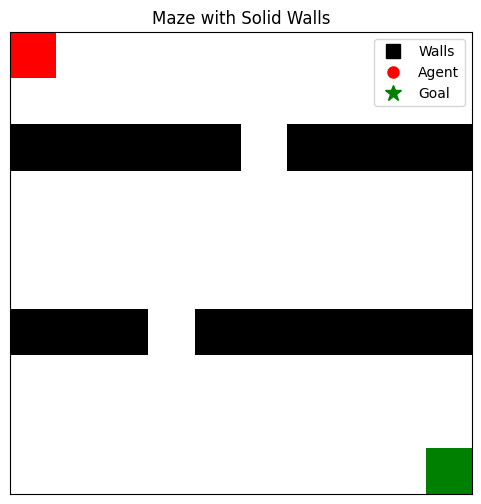

Episode 0: Steps=775, Best=775
Episode 1: Steps=2848, Best=775
Episode 2: Steps=271, Best=271
Episode 3: Steps=1997, Best=271
Episode 4: Steps=472, Best=271
Episode 5: Steps=1250, Best=271
Episode 6: Steps=1182, Best=271
Episode 7: Steps=137, Best=137
Episode 8: Steps=245, Best=137
Episode 9: Steps=2083, Best=137
Episode 10: Steps=1674, Best=137
Episode 11: Steps=1001, Best=137
Episode 12: Steps=1244, Best=137
Episode 13: Steps=3310, Best=137
Episode 14: Steps=313, Best=137
Episode 15: Steps=2130, Best=137
Episode 16: Steps=2194, Best=137
Early stopping at episode 17 (no improvement for 10 episodes)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchbnn as bnn
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import colors

class Maze:
    def __init__(self, size=10):
        self.size = size
        self.grid = np.zeros((size, size))
        self.goal = (size-1, size-1)
        self.walls = self._create_walls()
        self.reset()

    def _create_walls(self):
        """Create horizontal walls to make a snakelike path"""
        walls = set()
        # Add horizontal walls at rows 2 and 6, leaving openings
        for y in range(self.size):
            if y != 5:  # Leave an opening at column 5
                walls.add((2, y))  # First horizontal wall
            if y != 3:  # Leave an opening at column 3
                walls.add((6, y))  # Second horizontal wall
        return walls

    def reset(self):
        self.agent_pos = (0, 0)
        return self.agent_pos

    def step(self, action):
        x, y = self.agent_pos
        new_x, new_y = x, y

        if action == 0 and x > 0:           new_x -= 1  # Up
        elif action == 1 and y < self.size-1: new_y += 1  # Right
        elif action == 2 and x < self.size-1: new_x += 1  # Down
        elif action == 3 and y > 0:           new_y -= 1  # Left

        # Check for wall collisions
        if (new_x, new_y) not in self.walls:
            self.agent_pos = (new_x, new_y)

        done = (self.agent_pos == self.goal)
        reward = 1 if done else -0.01
        return self.agent_pos, reward, done

    def render(self):
        """Visualize maze with solid walls using imshow"""
        # Create grid: 0=empty, 1=wall, 2=agent, 3=goal
        vis_grid = np.zeros((self.size, self.size))

        # Mark walls
        for (x, y) in self.walls:
            vis_grid[x, y] = 1

        # Mark agent and goal (will be plotted separately)
        vis_grid[self.agent_pos] = 2
        vis_grid[self.goal] = 3

        # Create custom colormap
        cmap = colors.ListedColormap(['white', 'black', 'red', 'green'])
        bounds = [0, 1, 2, 3, 4]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        plt.figure(figsize=(6,6))
        plt.imshow(vis_grid, cmap=cmap, norm=norm)

        # Add legend
        plt.plot([], [], 's', color='black', markersize=10, label='Walls')
        plt.plot([], [], 'o', color='red', markersize=8, label='Agent')
        plt.plot([], [], '*', color='green', markersize=12, label='Goal')
        plt.legend(loc='upper right')

        plt.title("Maze with Solid Walls")
        plt.xticks([])
        plt.yticks([])
        plt.show()

class BayesianDQN(torch.nn.Module):
    def __init__(self, state_dim=2, action_dim=4):
        super().__init__()
        self.fc1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=state_dim, out_features=32)
        self.fc2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=32, out_features=action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

def train_and_animate(maze, episodes=500, early_stop=True):
    model = BayesianDQN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = bnn.BKLLoss(reduction='mean', last_layer_only=False)

    uncertainty_history = []
    episode_metrics = []
    best_steps = float('inf')
    patience = 10
    no_improve = 0

    for ep in range(episodes):
        state = maze.reset()
        done = False
        steps = 0

        while not done:
            state_tensor = torch.FloatTensor(state)
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()
            next_state, reward, done = maze.step(action)

            target = reward + 0.99 * torch.max(model(torch.FloatTensor(next_state)))
            loss = torch.nn.MSELoss()(q_values[action], target) + criterion(model)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            steps += 1
            state = next_state

        if early_stop:
            if steps < best_steps:
                best_steps = steps
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= patience:
                print(f"Early stopping at episode {ep} (no improvement for {patience} episodes)")
                break

        if ep % 1 == 0:
            uncertainty_map = generate_uncertainty_map(model, maze)
            uncertainty_history.append(uncertainty_map)
            episode_metrics.append((ep, steps, best_steps))
            print(f"Episode {ep}: Steps={steps}, Best={best_steps}")

    return create_animation(uncertainty_history, episode_metrics, maze)

def generate_uncertainty_map(model, maze):
    """Generate uncertainty map with walls marked as -1"""
    uncertainty_map = np.zeros((maze.size, maze.size))
    for x in range(maze.size):
        for y in range(maze.size):
            if (x, y) in maze.walls:
                uncertainty_map[x, y] = -1  # Special value for walls
            else:
                state = torch.FloatTensor([x, y])
                q_samples = [model(state).detach().numpy() for _ in range(10)]
                uncertainty_map[x, y] = np.std(q_samples, axis=0).mean()
    return uncertainty_map

def create_animation(uncertainty_history, episode_metrics, maze):
    """Create animation with solid walls"""
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.close()

    # Create colormap for animation (walls will be black)
    cmap = plt.cm.hot.copy()
    cmap.set_bad('black')  # Walls shown as black

    # Initial plot
    masked_data = np.ma.masked_where(uncertainty_history[0] == -1, uncertainty_history[0])
    im = ax.imshow(masked_data, cmap=cmap, vmin=0, vmax=1)

    # Add static wall visualization
    wall_grid = np.zeros((maze.size, maze.size))
    for (x,y) in maze.walls:
        wall_grid[x,y] = 1
    ax.imshow(wall_grid, cmap=colors.ListedColormap(['none', 'black']), alpha=0.3)

    # Add agent and goal markers (updated in render)
    agent_marker, = ax.plot([], [], 'ro', markersize=8)
    goal_marker, = ax.plot([], [], 'g*', markersize=12)

    cbar = fig.colorbar(im, ax=ax, label='Uncertainty (Std Dev)')
    title = ax.set_title(f'Episode {episode_metrics[0][0]}\nSteps: {episode_metrics[0][1]}, Best: {episode_metrics[0][2]}')

    def update(frame):
        # Update uncertainty heatmap
        masked_data = np.ma.masked_where(uncertainty_history[frame] == -1, uncertainty_history[frame])
        im.set_array(masked_data)

        # Update title
        ep, steps, best = episode_metrics[frame]
        title.set_text(f'Episode {ep}\nSteps: {steps}, Best: {best}')

        return im, title

    ani = FuncAnimation(
        fig,
        update,
        frames=len(uncertainty_history),
        interval=300,
        blit=False
    )

    return HTML(ani.to_jshtml())

if __name__ == "__main__":
    maze = Maze(size=10)
    maze.render()  # Show initial maze with solid walls
    animation = train_and_animate(maze)
    display(animation)

In [ ]:
# In scripts: Use ani.save('uncertainty_evolution.mp4')